LLMs vs True Outcome
                   accuracy  precision  recall     f1    auc    mse    mae
GPT-4o (prompt 5)     0.667      0.636   0.538  0.583  0.652  0.333  0.333
GPT-4o (prompt 6)     0.467      0.448   1.000  0.619  0.529  0.533  0.533
Qwen (prompt 5)       0.567      0.500   0.846  0.629  0.600  0.433  0.433
Qwen (prompt 6)       0.467      0.440   0.846  0.579  0.511  0.533  0.533
Gemini (prompt 5)     0.567      0.500   0.846  0.629  0.600  0.433  0.433
Gemini (prompt 6)     0.500      0.458   0.846  0.595  0.541  0.500  0.500

Human Prediction vs True Outcome
                  accuracy  precision  recall     f1   auc   mse    mae
Human Prediction     0.733      0.692   0.692  0.692  0.69  0.23  0.377

LLMs vs Human Prediction
                   accuracy  precision  recall     f1    auc    mse    mae
GPT-4o (prompt 5)     0.533      0.455   0.385  0.417  0.516  0.467  0.467
GPT-4o (prompt 6)     0.467      0.448   1.000  0.619  0.529  0.533  0.533
Qwen (prompt 5)       0.7

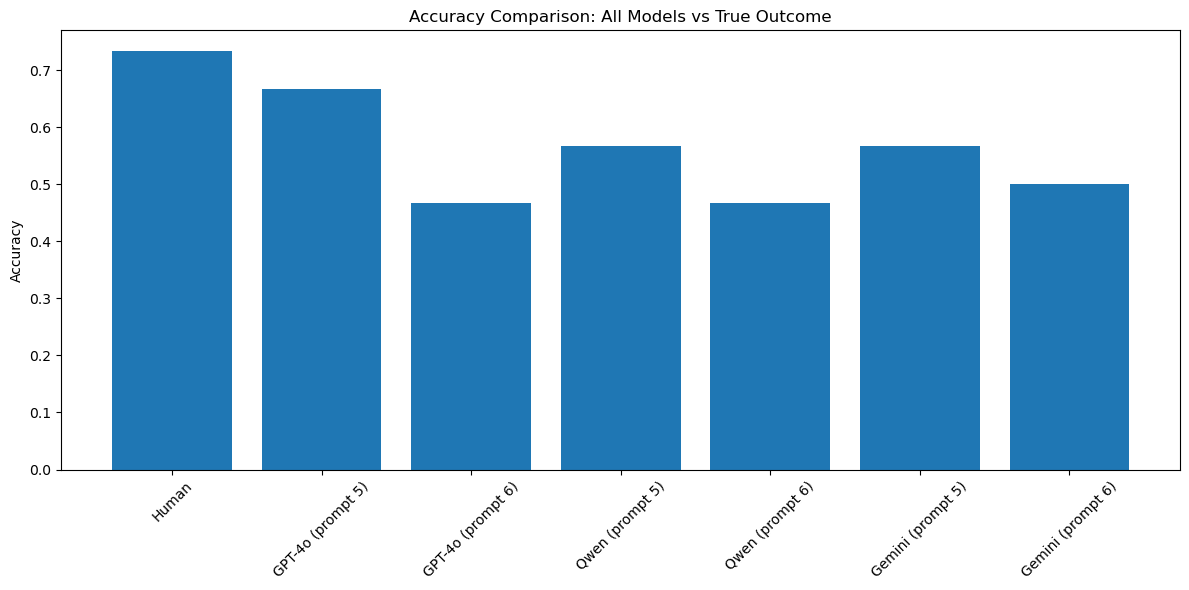

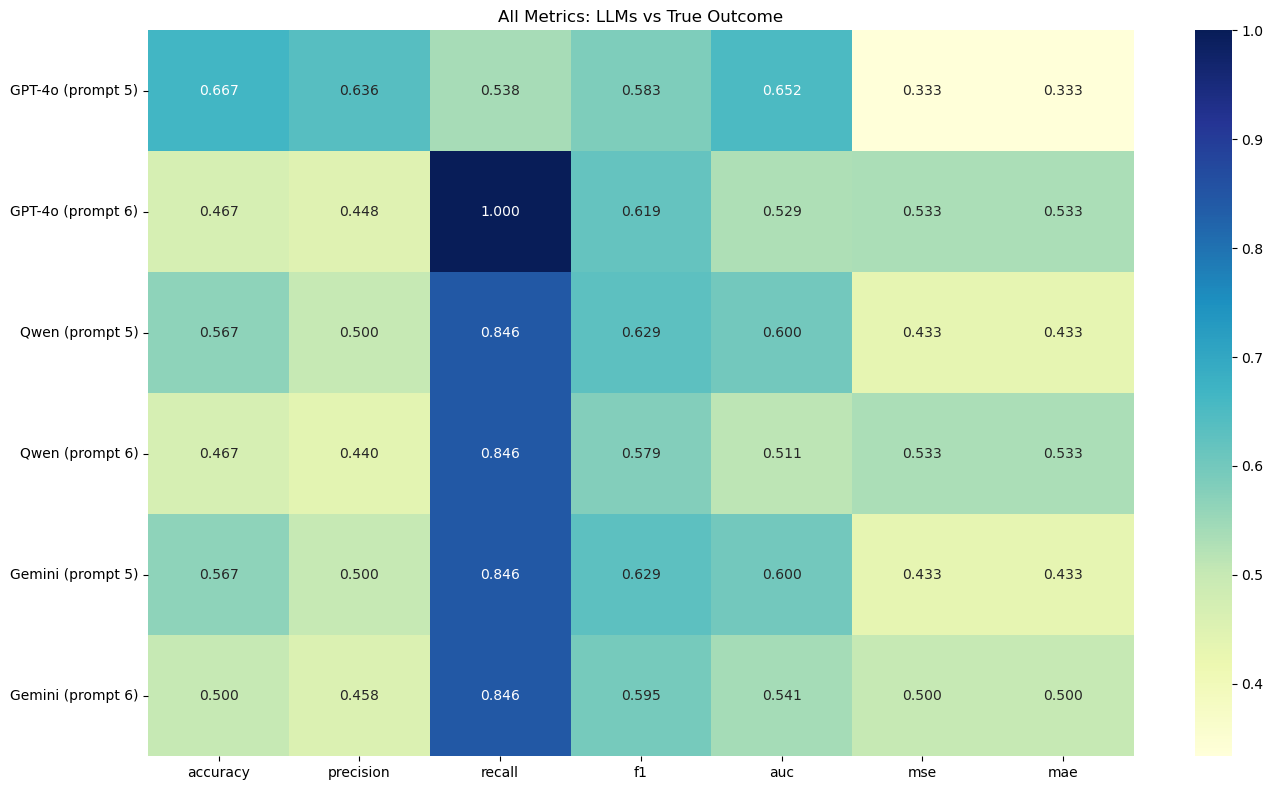

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns

# Load the data
df = pd.read_csv('analyze-predictions.csv')

# Define a function to convert continuous predictions to binary (using 0.5 as threshold)
def to_binary(series, threshold=0.5):
    # Check if the series already contains only 0s and 1s
    unique_values = set(series.unique())
    if unique_values.issubset({0, 1}) or unique_values.issubset({0.0, 1.0}):
        return series.astype(int)  # Already binary, just ensure int type
    
    # For continuous values, convert to binary based on threshold
    return (series >= threshold).astype(int)

# Define a function to calculate all metrics
def calculate_metrics(y_true, y_pred_prob):
    y_pred = to_binary(y_pred_prob)
    
    # Handle cases where only one class is present
    try:
        auc = roc_auc_score(y_true, y_pred_prob)
    except:
        auc = np.nan
        
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'auc': auc,
        'mse': np.mean((y_true - y_pred_prob) ** 2),
        'mae': np.mean(np.abs(y_true - y_pred_prob))
    }
    return metrics

# ----- LLMs vs True Outcome -----
print("="*50)
print("LLMs vs True Outcome")
print("="*50)

# Define models and prompts
models = ['GPT-4o', 'Qwen', 'Gemini']
prompts = ['prompt 5', 'prompt 6']

# Calculate metrics for each model and prompt combination
metrics_vs_true = {}
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        metrics_vs_true[f"{model} ({prompt})"] = calculate_metrics(df['True Outcome'], df[col_name])

# Convert to DataFrame for easier comparison
metrics_df_vs_true = pd.DataFrame(metrics_vs_true).T
print(metrics_df_vs_true.round(3))

# ----- Human Prediction vs True Outcome -----
print("\n" + "="*50)
print("Human Prediction vs True Outcome")
print("="*50)

human_metrics = calculate_metrics(df['True Outcome'], df['Average Class of Human Predicion'])
human_df = pd.DataFrame(human_metrics, index=['Human Prediction'])
print(human_df.round(3))

# ----- LLMs vs Human Prediction -----
print("\n" + "="*50)
print("LLMs vs Human Prediction")
print("="*50)

metrics_vs_human = {}
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        
        # Convert human predictions to binary for comparison with binary LLM predictions
        human_binary = to_binary(df['Average Class of Human Predicion'])
        
        metrics_vs_human[f"{model} ({prompt})"] = calculate_metrics(human_binary, df[col_name])

metrics_df_vs_human = pd.DataFrame(metrics_vs_human).T
print(metrics_df_vs_human.round(3))

# ----- Visualization -----
# Create a bar chart to compare accuracy of all models against true outcome
plt.figure(figsize=(12, 6))
accuracy_comparison = {
    'Human': human_metrics['accuracy']
}

for model in models:
    for prompt in prompts:
        key = f"{model} ({prompt})"
        accuracy_comparison[key] = metrics_vs_true[key]['accuracy']

plt.bar(accuracy_comparison.keys(), accuracy_comparison.values())
plt.title('Accuracy Comparison: All Models vs True Outcome')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('accuracy_comparison.png')

# Create a heatmap to visualize all metrics for all models against true outcome
plt.figure(figsize=(14, 8))
sns.heatmap(metrics_df_vs_true, annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('All Metrics: LLMs vs True Outcome')
plt.tight_layout()
plt.savefig('metrics_heatmap.png')

# ----- Advanced Analysis -----
# Calculate agreement rate between models
print("\n" + "="*50)
print("Model Agreement Analysis")
print("="*50)

agreement_df = pd.DataFrame(index=models, columns=models)
for model1 in models:
    for model2 in models:
        if model1 == model2:
            agreement_df.loc[model1, model2] = 1.0
            continue
            
        # Calculate agreement rate for prompt 5
        pred1 = to_binary(df[f"{model1} Prediction (prompt 5)"])
        pred2 = to_binary(df[f"{model2} Prediction (prompt 5)"])
        agreement_rate = np.mean(pred1 == pred2)
        agreement_df.loc[model1, model2] = agreement_rate

print("Model Agreement Rate (prompt 5):")
print(agreement_df.round(3))

# Calculate correlation between model predictions
print("\n" + "="*50)
print("Correlation Analysis")
print("="*50)

# Extract the prediction columns
pred_columns = [f"{model} Prediction ({prompt})" for model in models for prompt in prompts]
pred_columns.append('Average Class of Human Predicion')
pred_columns.append('True Outcome')

# Calculate correlation matrix
corr_matrix = df[pred_columns].corr()
print(corr_matrix.round(3))

# ----- Per Video Analysis -----
print("\n" + "="*50)
print("Per Video Performance")
print("="*50)

# Calculate accuracy per video for each model
video_performance = pd.DataFrame(index=df['Video'].unique())

# Add human performance
video_performance['Human Accuracy'] = [
    accuracy_score(
        df.loc[df['Video'] == video, 'True Outcome'], 
        to_binary(df.loc[df['Video'] == video, 'Average Class of Human Predicion'])
    )
    for video in video_performance.index
]

# Add model performances
for model in models:
    for prompt in prompts:
        col_name = f"{model} ({prompt}) Accuracy"
        video_performance[col_name] = [
            accuracy_score(
                df.loc[df['Video'] == video, 'True Outcome'], 
                df.loc[df['Video'] == video, f"{model} Prediction ({prompt})"]
            )
            for video in video_performance.index
        ]

# Top 5 hardest videos (lowest human accuracy)
print("Top 5 Hardest Videos (Lowest Human Accuracy):")
print(video_performance.sort_values('Human Accuracy').head(5))

# Top 5 easiest videos (highest human accuracy)
print("\nTop 5 Easiest Videos (Highest Human Accuracy):")
print(video_performance.sort_values('Human Accuracy', ascending=False).head(5))

# ----- Summary Statistics -----
print("\n" + "="*50)
print("Summary Statistics")
print("="*50)

# Calculate average accuracy across all videos
avg_acc = {
    'Human': video_performance['Human Accuracy'].mean()
}

for model in models:
    for prompt in prompts:
        avg_acc[f"{model} ({prompt})"] = video_performance[f"{model} ({prompt}) Accuracy"].mean()

# Print summary
for name, acc in avg_acc.items():
    print(f"{name}: Average Accuracy = {acc:.3f}")

# Count videos where each model outperforms humans
for model in models:
    for prompt in prompts:
        outperform_count = (video_performance[f"{model} ({prompt}) Accuracy"] > video_performance['Human Accuracy']).sum()
        total_videos = len(video_performance)
        print(f"{model} ({prompt}) outperforms humans on {outperform_count}/{total_videos} videos ({outperform_count/total_videos*100:.1f}%)")

In [2]:
print("\n" + "="*50)
print("Creating Additional Visualizations")
print("="*50)

# 1. Confusion matrices for each model vs true outcome
plt.figure(figsize=(18, 12))
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Confusion Matrices: Models vs True Outcome', fontsize=16)

# Flatten for easier indexing if needed
axs = axs.flatten()

# Add human predictions
human_binary = to_binary(df['Average Class of Human Predicion'])
cm_human = confusion_matrix(df['True Outcome'], human_binary)
sns.heatmap(cm_human, annot=True, fmt='d', cmap='Blues', ax=axs[0],
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
axs[0].set_title('Human Predictions vs True Outcome')

# Add each model
i = 1
for model in models:
    for prompt in ['prompt 5']:  # Just use prompt 5 for simplicity
        col_name = f"{model} Prediction ({prompt})"
        cm = confusion_matrix(df['True Outcome'], df[col_name])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[i],
                    xticklabels=['Predicted 0', 'Predicted 1'],
                    yticklabels=['Actual 0', 'Actual 1'])
        axs[i].set_title(f'{model} ({prompt}) vs True Outcome')
        i += 1

# If there are empty subplots, hide them
if i < len(axs):
    for j in range(i, len(axs)):
        axs[j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for suptitle
plt.savefig('confusion_matrices.png')
plt.close()

# 2. ROC curves for models with continuous predictions
plt.figure(figsize=(10, 8))
from sklearn.metrics import roc_curve, auc

# For human predictions (continuous)
fpr_human, tpr_human, _ = roc_curve(df['True Outcome'], df['Average Class of Human Predicion'])
roc_auc_human = auc(fpr_human, tpr_human)
plt.plot(fpr_human, tpr_human, label=f'Human (AUC = {roc_auc_human:.3f})')

# For models (assuming binary predictions, but we can plot them anyway)
for model in models:
    for prompt in prompts:
        col_name = f"{model} Prediction ({prompt})"
        try:
            fpr, tpr, _ = roc_curve(df['True Outcome'], df[col_name])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{model} ({prompt}) (AUC = {roc_auc:.3f})')
        except:
            print(f"Couldn't create ROC curve for {model} ({prompt}) - possibly binary predictions only")

plt.plot([0, 1], [0, 1], 'k--')  # Random prediction line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves: Models vs True Outcome')
plt.legend(loc="lower right")
plt.savefig('roc_curves.png')
plt.close()

# 3. Model agreement heatmap
plt.figure(figsize=(12, 10))
all_cols = ['Average Class of Human Predicion', 'True Outcome']
for model in models:
    for prompt in prompts:
        all_cols.append(f"{model} Prediction ({prompt})")

# Create a matrix to show how often each pair of predictors agrees
agreement_matrix = np.zeros((len(all_cols), len(all_cols)))

for i, col1 in enumerate(all_cols):
    for j, col2 in enumerate(all_cols):
        if i == j:
            agreement_matrix[i, j] = 1.0
        else:
            # Convert to binary if needed
            pred1 = to_binary(df[col1]) if col1 == 'Average Class of Human Predicion' else df[col1]
            pred2 = to_binary(df[col2]) if col2 == 'Average Class of Human Predicion' else df[col2]
            agreement_matrix[i, j] = np.mean(pred1 == pred2)

# Create a nice heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(agreement_matrix, annot=True, cmap='YlGnBu', 
            xticklabels=[col.replace(' Prediction', '').replace('Average Class of ', '') for col in all_cols],
            yticklabels=[col.replace(' Prediction', '').replace('Average Class of ', '') for col in all_cols],
            fmt='.3f')
plt.title('Agreement Matrix Between Different Predictions')
plt.tight_layout()
plt.savefig('agreement_matrix.png')
plt.close()

# 4. Per-video performance comparison
plt.figure(figsize=(20, 10))
# Sort videos by human performance for better visualization
sorted_videos = video_performance.sort_values('Human Accuracy').index.tolist()
video_performance_sorted = video_performance.loc[sorted_videos]

# Plot performance for each video
plt.figure(figsize=(20, 10))
video_performance_sorted.plot(kind='bar', figsize=(20, 10))
plt.title('Performance by Video: Human vs LLMs')
plt.xlabel('Video')
plt.ylabel('Accuracy')
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('video_performance.png')
plt.close()

# 5. Distribution of human prediction values
plt.figure(figsize=(10, 6))
plt.hist(df['Average Class of Human Predicion'], bins=20, alpha=0.7)
plt.axvline(x=0.5, color='r', linestyle='--', label='Decision Boundary')
plt.title('Distribution of Human Prediction Values')
plt.xlabel('Prediction Value')
plt.ylabel('Frequency')
plt.legend()
plt.savefig('human_prediction_distribution.png')
plt.close()

# 6. Create box plots to show variance in predictions across models
plt.figure(figsize=(12, 8))
accuracy_data = []
labels = []

# Add human data
accuracy_data.append(video_performance['Human Accuracy'])
labels.append('Human')

# Add model data
for model in models:
    for prompt in prompts:
        accuracy_data.append(video_performance[f"{model} ({prompt}) Accuracy"])
        labels.append(f"{model} ({prompt})")

plt.boxplot(accuracy_data, labels=labels)
plt.title('Distribution of Accuracy Across Videos')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('accuracy_distribution.png')
plt.close()


Creating Additional Visualizations


<Figure size 1800x1200 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>